In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import arviz as az

import pymc3 as pm

import pyro
import torch
from pyro.optim import Adam
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, NUTS
from torch.distributions import constraints
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal

%matplotlib inline

In [2]:
df = pd.read_csv("data/WaffleDivorce.csv", sep=";")
# Standardize input
df['MedianAgeMarriage_s'] = (df.MedianAgeMarriage - df.MedianAgeMarriage.mean()) / df.MedianAgeMarriage.std()
df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,MedianAgeMarriage_s
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857


# 1. Training set only

In [3]:
x = df.MedianAgeMarriage_s.values
y = df.Divorce.values
num_examples = len(x)
num_examples

50

### PyMC3 

In [4]:
with pm.Model() as model:
    w = pm.Normal('w', mu=10, sd=10)
    b = pm.Normal('b', mu=0, sd=1)
    # If we put mu in Deterministic, it appears in the trace
    mu = pm.Deterministic('mu', b + w * x)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # Alternative without hard boundary
    # sigma = pm.HalfNormal('sigma', 5)
    obs = pm.Normal('y', mu=mu, sd=sigma, observed=y)
    # Printing the shape of random variable
    print(obs.init_value.shape)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


(50,)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, w]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1605.88draws/s]


['w', 'b', 'sigma_interval__', 'mu', 'sigma']


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
w,-1.09,0.24,-1.55,-0.66,0.0,0.0,4381.0,4259.0,4378.0,2820.0,1.0
b,9.21,0.26,8.74,9.68,0.0,0.0,2682.0,2682.0,2760.0,2056.0,1.0
mu[0],9.87,0.29,9.34,10.42,0.0,0.0,2900.0,2900.0,2983.0,2379.0,1.0


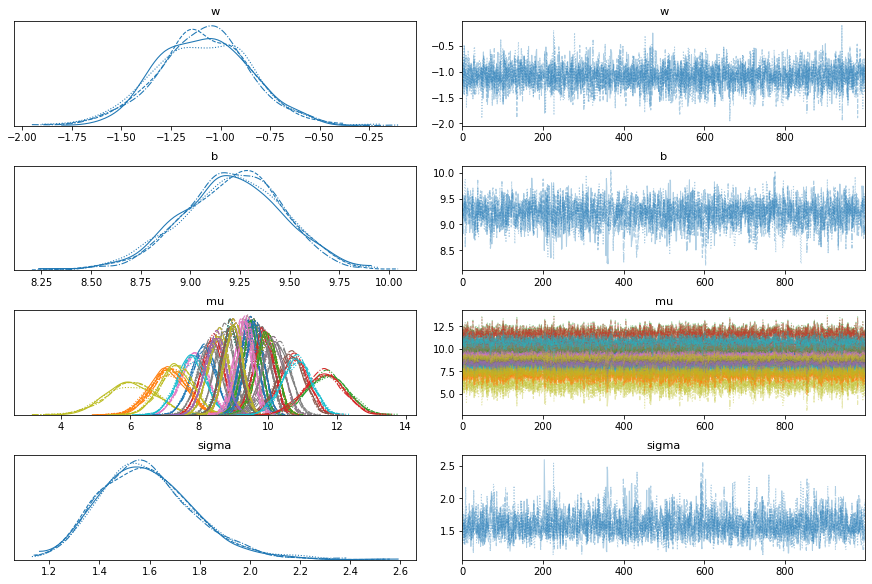

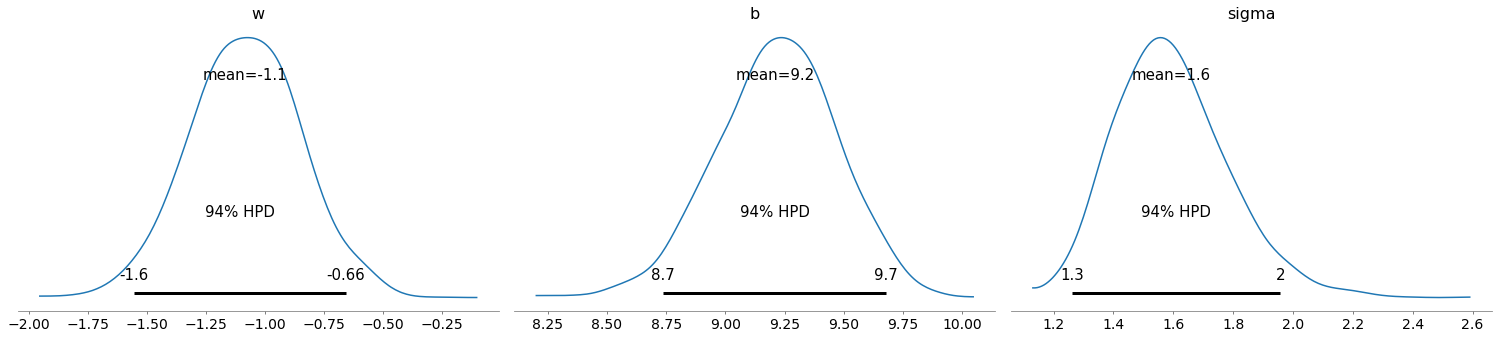

In [5]:
# Useful diagnostic functions
print(trace.varnames)
data = az.from_pymc3(trace=trace)
display(az.summary(data)[:3].round(2))
az.plot_trace(data, compact=True)
az.plot_posterior(data, var_names=["w", "b", "sigma"]);

In [6]:
model.basic_RVs

[w, b, sigma_interval__, y]

In [7]:
model.free_RVs

[w, b, sigma_interval__]

In [8]:
model.observed_RVs

[y]

In [9]:
model.deterministics

[mu, sigma]

In [10]:
# Evaluate log probability of the training set with mean posterior parameters
posterior_means = {var: trace[var].mean(axis=0) for var in model.free_RVs}
print(posterior_means)
print("Log probability =", model.logp(posterior_means) / num_examples)

{w: -1.0858962254692106, b: 9.211383053510755, sigma_interval__: -1.6689335075230007}
Log probability = -2.824639882392608


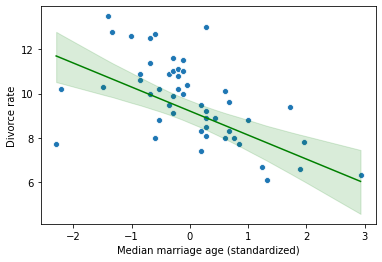

In [11]:
def plot_predictions(x, y, samples):
    # Sort values for plotting
    idxs = np.argsort(x)
    x, y, samples = x[idxs], y[idxs], samples[:, idxs]
    
    mean = samples.mean(axis=0)
    low, high = np.percentile(samples, (2.5, 97.5), axis=0)

    ax = sns.scatterplot(x, y)
    ax.set(xlabel="Median marriage age (standardized)", ylabel="Divorce rate")
    ax.plot(x, mean, color='green')
    ax.fill_between(x, high, low, color='green', alpha=0.15)

plot_predictions(x, y, trace["mu"])

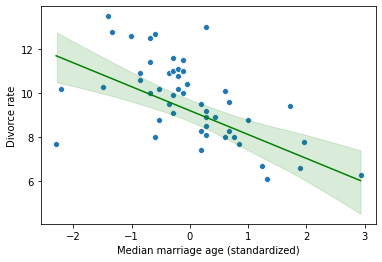

In [12]:
def plot_predictions(x, y, samples):
    # Same function using ArviZ for credible interval
    idxs = np.argsort(x)
    x, y, samples = x[idxs], y[idxs], samples[:, idxs]
    mean = samples.mean(axis=0)
    ax = sns.scatterplot(x, y)
    ax.set(xlabel="Median marriage age (standardized)", ylabel="Divorce rate")
    ax.plot(x, mean, color='green')
    az.plot_hpd(x, samples, color='green', credible_interval=0.95,
                fill_kwargs={'alpha': 0.15})

plot_predictions(x, y, trace["mu"])

### Pyro MCMC

In [13]:
# The Pyro interface is cleaner:
# - separation between model and MCMC
# - model is a function with arguments
x, y = torch.as_tensor(x), torch.as_tensor(y)

def model(x, y):
    b = pyro.sample("b", dist.Normal(10, 10))
    w = pyro.sample("w", dist.Normal(0, 1))
    mu = b + w * x
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        y = pyro.sample("y", dist.Normal(mu, sigma), obs=y)

# MCMC in Pyro is MUCH slower than PyMC3 
# Multiple chains does not work
mcmc = MCMC(NUTS(model),
            num_samples=1000,
            warmup_steps=1000,
            num_chains=1)
mcmc.run(x, y)

# Extract samples
trace = mcmc.get_samples()
print(trace.keys())

Sample: 100%|██████████| 2000/2000 [00:21, 93.25it/s, step size=7.01e-01, acc. prob=0.929] 

dict_keys(['b', 'w', 'sigma'])


In [14]:
mcmc.summary()
# It's currently not straightforward to evaluate the log probability 
# of the training set with mean posterior parameters because the API
# is still changing. MCMC used to be a subclass of TracePosterior and
# and we could use EmpiricalMarginal, but it's not the case anymore.


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      9.68      0.21      9.69      9.32      9.99    812.02      1.00
         w     -1.03      0.20     -1.03     -1.34     -0.67    836.77      1.00
     sigma      1.52      0.16      1.50      1.25      1.76    924.95      1.00

Number of divergences: 0


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b,9.68,0.21,9.30,10.07,0.01,0.0,810.0,810.0,816.0,786.0,NaN
w,-1.03,0.20,-1.38,-0.62,0.01,0.0,836.0,836.0,834.0,516.0,NaN
sigma,1.52,0.16,1.23,1.82,0.00,0.0,914.0,880.0,963.0,723.0,NaN


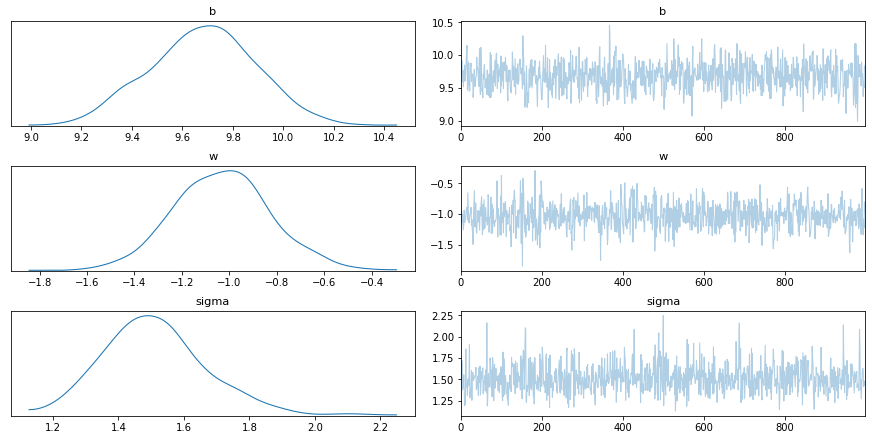

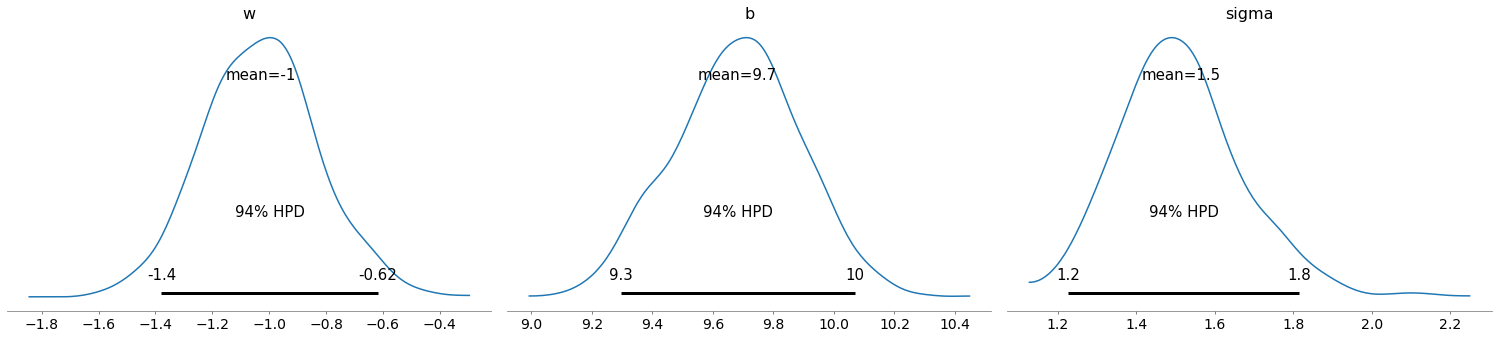

In [15]:
# Work directly with MCMC object with ArviZ
data = az.from_pyro(mcmc)
display(az.summary(data)[:3].round(2))
az.plot_trace(data, compact=True)
az.plot_posterior(data, var_names=["w", "b", "sigma"]);

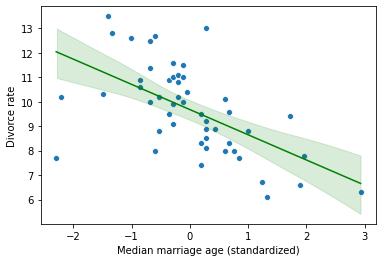

In [16]:
w = trace["w"].view(-1, 1)
b = trace["b"].view(-1, 1)
mu = b + w * x 
plot_predictions(x, y, mu)

# 2. With test set

In [17]:
x = df.MedianAgeMarriage_s.values
y = df.Divorce.values
num_test = len(x) // 5
num_train = len(x) - num_test
x_train, x_test = x[num_test:], x[:num_test]
y_train, y_test = y[num_test:], y[:num_test]
num_train, num_test

(40, 10)

### PyMC3

In [18]:
def model_factory(x, y):
    with pm.Model() as model:
        w = pm.Normal('w', mu=10, sd=10)
        b = pm.Normal('b', mu=0, sd=1)
        # If enclose mu in Deterministic it fails: no sampled parameter
        # must have its shape determined by the training dataset
        mu = b + w * x
        sigma = pm.Uniform('sigma', lower=0, upper=10)
        obs = pm.Normal('y', mu=mu, sd=sigma, observed=y)
    return model

# Perform the training to get the trace
with model_factory(x_train, y_train) as model_train:
    trace_train = pm.sample(1000, tune=1000)
    ppc_train = pm.sample_posterior_predictive(trace_train)
    
with model_factory(x_test, y_test) as model_test:
    ppc_test = pm.sample_posterior_predictive(trace_train)
    
print(ppc_train.keys(), ppc_train['y'].shape, ppc_test['y'].shape)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, w]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:05<00:00, 1576.93draws/s]
The acceptance probability does not match the target. It is 0.6280732559096421, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 4000/4000 [00:03<00:00, 1192.17it/s]

dict_keys(['y']) (4000, 40) (4000, 10)


In [19]:
posterior_means = {var: trace_train[var].mean(axis=0) for var in model_train.free_RVs}
print(posterior_means)
print("Train log probability =", model_train.logp(posterior_means) / num_train)
print("Test log probability =", model_test.logp(posterior_means) / num_test)

{w: -0.8347046948745199, b: 8.985422322116632, sigma_interval__: -1.660816185777068}
Train log probability = -3.015026048386685
Test log probability = -6.890336355526091


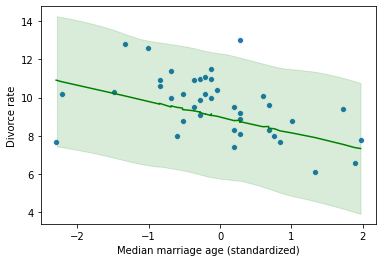

In [20]:
plot_predictions(x_train, y_train, ppc_train['y'])

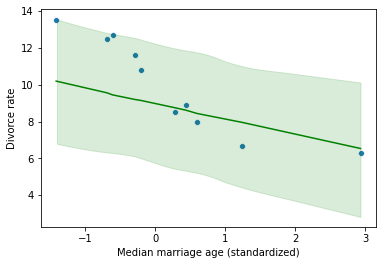

In [21]:
plot_predictions(x_test, y_test, ppc_test['y'])

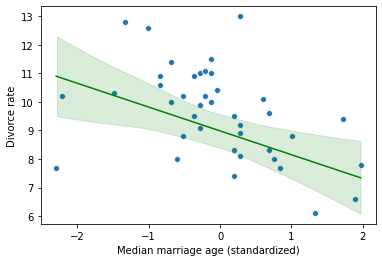

In [22]:
b = trace_train['b'].reshape(-1, 1)
w = trace_train['w'].reshape(-1, 1)
mu_train = b + w * x_train
plot_predictions(x_train, y_train, mu_train)

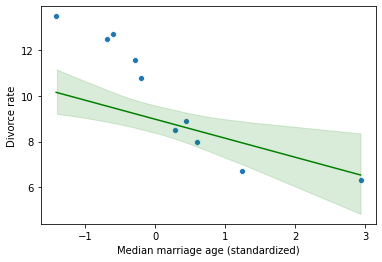

In [23]:
mu_test = b + w * x_test
plot_predictions(x_test, y_test, mu_test)

### Pyro MCMC

In [24]:
x_train, y_train, x_test, y_test = [torch.as_tensor(t) for t 
                                    in (x_train, y_train, x_test, y_test)]

In [25]:
def model(x, y=None):
    b = pyro.sample("b", dist.Normal(10, 10))
    w = pyro.sample("w", dist.Normal(0, 1))
    mu = b + w * x
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        y = pyro.sample("y", dist.Normal(mu, sigma), obs=y)

mcmc = MCMC(NUTS(model),
            num_samples=1000,
            warmup_steps=1000,
            num_chains=1)
mcmc.run(x_train, y_train)
trace_train = mcmc.get_samples()

Sample: 100%|██████████| 2000/2000 [00:19, 104.08it/s, step size=8.62e-01, acc. prob=0.903]


dict_keys(['y']) torch.Size([1000, 40]) torch.Size([1000, 10])


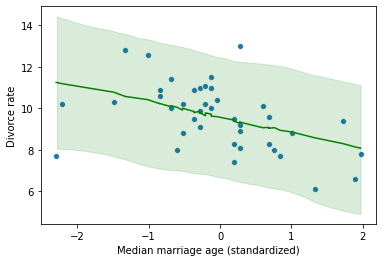

In [26]:
predictive = Predictive(model, posterior_samples=trace_train)
ppc_train = predictive(x_train)
ppc_test = predictive(x_test)
print(ppc_train.keys(), ppc_train['y'].shape, ppc_test['y'].shape)
plot_predictions(x_train, y_train, ppc_train['y'])

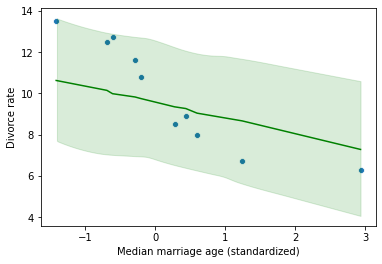

In [27]:
plot_predictions(x_test, y_test, ppc_test['y'])

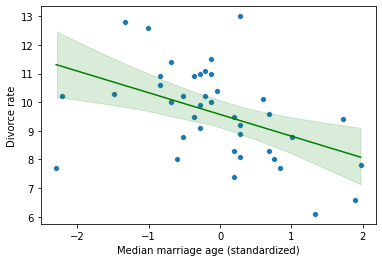

In [28]:
b = trace_train['b'].reshape(-1, 1)
w = trace_train['w'].reshape(-1, 1)
mu_train = b + w * x_train
plot_predictions(x_train, y_train, mu_train)

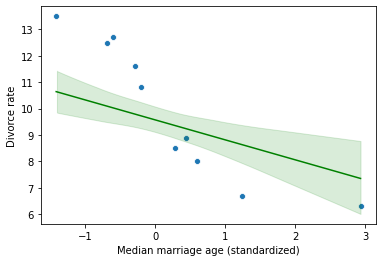

In [29]:
mu_test = b + w * x_test
plot_predictions(x_test, y_test, mu_test)

### Pyro variational inference

In [30]:
def model(x, y=None):
    b = pyro.sample("b", dist.Normal(10, 10))
    w = pyro.sample("w", dist.Normal(0, 1))
    mu = b + w * x
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        y = pyro.sample("y", dist.Normal(mu, sigma), obs=y)

# Automatic diagonal normal guide
guide = AutoDiagonalNormal(model)
    
optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Guide parameters are global variables
pyro.clear_param_store()
for step in range(1000):
    loss = svi.step(x_train, y_train)
    if step % 100 == 0:
        print(loss)

114.68960111674677
94.47319885073838
80.51443014961943
80.87319153970715
78.68518117202385
78.63195041672212
79.19262802933837
79.00459392063136
78.92478831164993
79.06120476197313


In [31]:
# We recover approximately the same posterior as with MCMC
with torch.no_grad():
    display(guide.quantiles([0.025, 0.5, 0.975]))

{'b': [tensor(9.1372), tensor(9.5715), tensor(10.0059)],
 'w': [tensor(-1.1167), tensor(-0.6664), tensor(-0.2160)],
 'sigma': [tensor(1.1675), tensor(1.4527), tensor(1.7935)]}

dict_keys(['b', 'w', 'sigma', 'y'])
torch.Size([1000, 10])


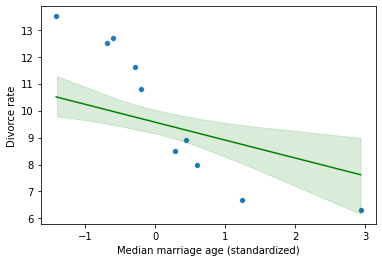

In [32]:
predictive = Predictive(model, guide=guide, num_samples=1000)

with torch.no_grad():
    ppc_test = predictive(x_test)
    
# Predictive for variational inference returns samples from the posterior
print(ppc_test.keys())
print(ppc_test['y'].shape)
mu_test = ppc_test['b'].view(-1, 1) + ppc_test['w'].view(-1, 1) * x_test
plot_predictions(x_test, y_test, mu_test)

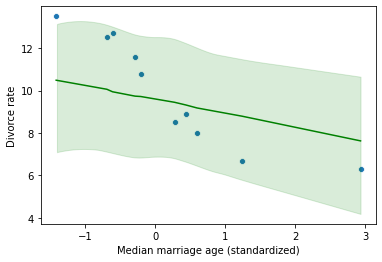

In [33]:
plot_predictions(x_test, y_test, ppc_test['y'])

In [34]:
def guide(x, y):
    # We must enforce positivity of scale parameters and sigma 
    # random variable and initialize scales to be narrow
    b_loc = pyro.param("b_loc", torch.tensor(10.))
    b_scale = pyro.param("b_scale", torch.tensor(0.1), constraint=constraints.positive)
    w_loc = pyro.param("w_loc", torch.tensor(0.))
    w_scale = pyro.param("w_scale", torch.tensor(0.1), constraint=constraints.positive)
    logsigma_loc = pyro.param("logsigma_loc", torch.tensor(0.))
    logsigma_scale = pyro.param("logsigma_scale", torch.tensor(0.1), constraint=constraints.positive)
    
    pyro.sample("w", dist.Normal(w_loc, w_scale))
    pyro.sample("b", dist.Normal(b_loc, b_scale))
    pyro.sample("sigma", dist.LogNormal(logsigma_loc, logsigma_scale))
    
optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Guide parameters are global variables
pyro.clear_param_store()
for step in range(1000):
    loss = svi.step(x_train, y_train)
    if step % 100 == 0:
        print(loss)

93.34973283730577
79.65044262211214
79.19166619178466
78.99630417108237
78.98173397900825
78.55913411736132
78.75397016596737
79.19158233093155
78.9551263993426
79.04127179623099
